In [68]:
# rdkit mols are displayed as images
from rdkit.Chem.Draw import IPythonConsole

from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import Scaffolds
from rdkit.Chem.Scaffolds import MurckoScaffold

# descriptors
from rdkit.Chem import Lipinski
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors

# diversity picker
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker

# plots
from matplotlib import pyplot
import seaborn

# scikit learn
# conda install -c conda-forge scikit-learn 
from scipy.spatial import distance
from sklearn import manifold
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn import preprocessing

# other packages
import pandas as pd
import csv
import re

In [2]:
float_pattern = re.compile("[0-9]+(\.[0-9]*)?")

In [3]:
lip_func = [("HBA", Lipinski.NumHAcceptors), ("HBD", Lipinski.NumHDonors), ("MW", Descriptors.ExactMolWt),
            ("LogP", Descriptors.MolLogP), ("TPSA", rdMolDescriptors.CalcTPSA), ("RB", Lipinski.NumRotatableBonds)]

In [4]:
with open("./cannabinoid_receptor_data.csv") as inp:
    data = [row for row in csv.DictReader(inp, delimiter=";", quotechar='"')]
    for m in data:
        m["rdmol"] = Chem.MolFromSmiles(m["Smiles"])
        m["source"] = "data"
        m["pChEMBL_value"] = float(m["pChEMBL Value"]) if float_pattern.match(m["pChEMBL Value"]) else 0
        m["fps"] = Chem.GetMorganFingerprintAsBitVect(m["rdmol"],2,nBits=1024)
        for f in lip_func:
            m[f[0]] = f[1](m["rdmol"])

In [5]:
%%capture
# %%capture hides stderr (and maybe all output)
# same for drugbank
drugbank = [{"rdmol": m,
             "source": "drugbank",
             "Smiles": Chem.MolToSmiles(m),
             "pChEMBL_value": 0,
             "fps": Chem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024),
             **{f[0]: f[1](m) for f in lip_func}
            } for m in Chem.SDMolSupplier("../data/drugbank.sdf") if m
           ]

[11:21:18] Explicit valence for atom # 7 N, 4, is greater than permitted
[11:21:18] ERROR: Could not sanitize molecule ending on line 20009
[11:21:18] ERROR: Explicit valence for atom # 7 N, 4, is greater than permitted
[11:21:20] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10

[11:21:20] ERROR: Could not sanitize molecule ending on line 250947
[11:21:20] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10

[11:21:20] Explicit valence for atom # 17 O, 3, is greater than permitted
[11:21:20] ERROR: Could not sanitize molecule ending on line 258130
[11:21:20] ERROR: Explicit valence for atom # 17 O, 3, is greater than permitted
[11:21:20] Can't kekulize mol.  Unkekulized atoms: 57 58 59 60 61 62 63 64 65

[11:21:20] ERROR: Could not sanitize molecule ending on line 261581
[11:21:20] ERROR: Can't kekulize mol.  Unkekulized atoms: 57 58 59 60 61 62 63 64 65

[11:21:20] Explicit valence for atom # 47 Mg, 4, is greater than permitted
[11:21:20] ERROR: Could not sani

[11:21:22] ERROR: Explicit valence for atom # 2 O, 3, is greater than permitted
[11:21:22] Explicit valence for atom # 6 B, 4, is greater than permitted
[11:21:22] ERROR: Could not sanitize molecule ending on line 541262
[11:21:22] ERROR: Explicit valence for atom # 6 B, 4, is greater than permitted
[11:21:23] Can't kekulize mol.  Unkekulized atoms: 2 3 17 19 20

[11:21:23] ERROR: Could not sanitize molecule ending on line 557517
[11:21:23] ERROR: Can't kekulize mol.  Unkekulized atoms: 2 3 17 19 20

[11:21:23] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 8 9 10

[11:21:23] ERROR: Could not sanitize molecule ending on line 561344
[11:21:23] ERROR: Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 8 9 10

[11:21:23] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 19

[11:21:23] ERROR: Could not sanitize molecule ending on line 562947
[11:21:23] ERROR: Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 19

[11:21:23] Explicit valence for atom # 27 N, 4, is greater than 

In [6]:
# let's work with Pandas dataframe
df = pd.DataFrame((*drugbank, *data), columns=["Smiles", "source", "rdmol", "fps", "pChEMBL_value", *(f[0] for f in lip_func)])
# adds index as normal column
df.reset_index(level=0, inplace=True)

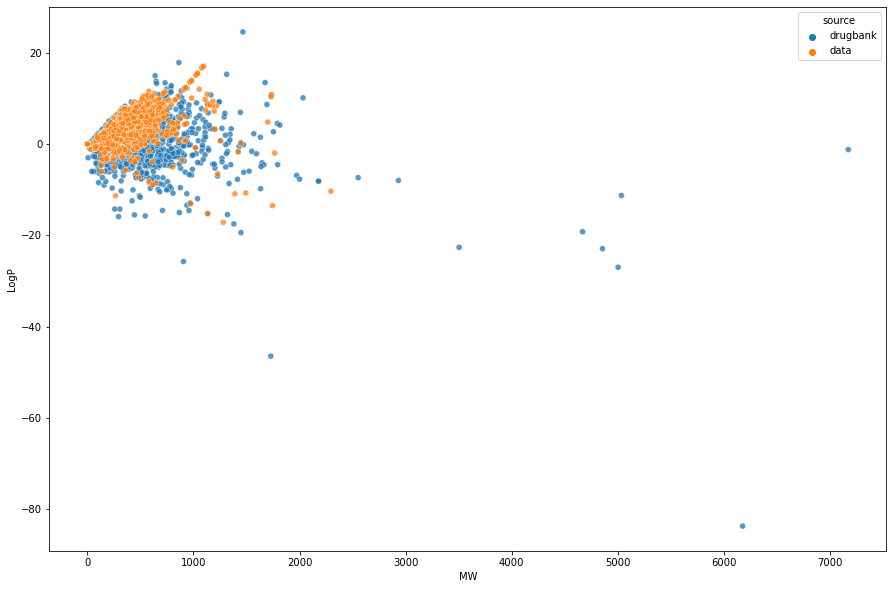

In [7]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="MW",
                      y="LogP",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

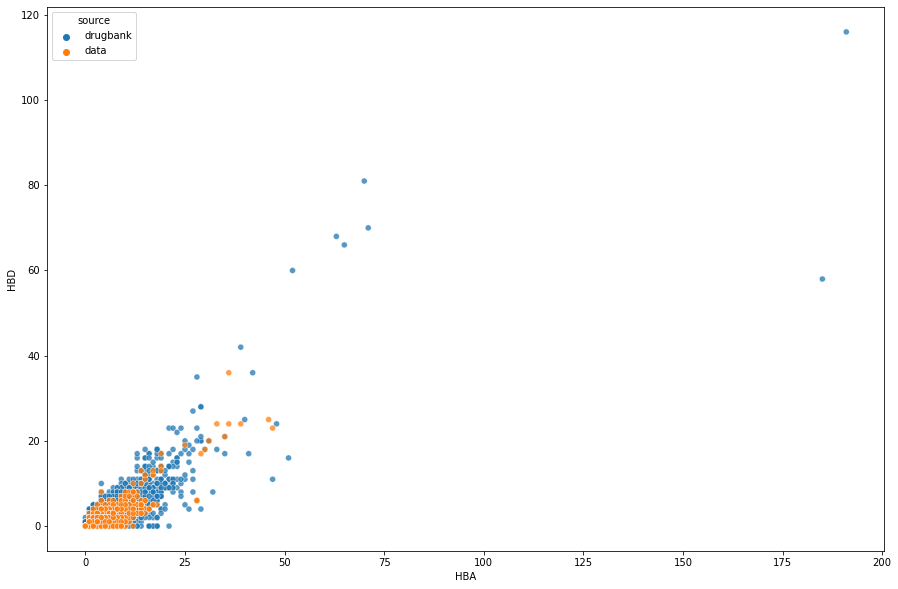

In [8]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="HBA",
                      y="HBD",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

In [9]:
df = df.join(pd.DataFrame((rdMolDescriptors.MQNs_(mol) for mol in df["rdmol"]),
                          columns=[*(f"MQN_{x}" for x in range(1,43))])
            )

In [10]:
df.head()

index                                             Smiles    source  \
0      0  CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...  drugbank   
1      1  CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...  drugbank   
2      2  N=C(N)NCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H]1...  drugbank   
3      3  CC(=O)N[C@H](Cc1ccc2ccccc2c1)C(=O)N[C@H](Cc1cc...  drugbank   
4      4  C/C=C/C[C@@H](C)[C@@H](O)[C@H]1C(=O)N[C@@H](CC...  drugbank   

                                              rdmol  \
0  <rdkit.Chem.rdchem.Mol object at 0x7fecd2d38260>   
1  <rdkit.Chem.rdchem.Mol object at 0x7fecd2d383a0>   
2  <rdkit.Chem.rdchem.Mol object at 0x7fecd2d38440>   
3  <rdkit.Chem.rdchem.Mol object at 0x7fecd2d384e0>   
4  <rdkit.Chem.rdchem.Mol object at 0x7fecd2d38580>   

                                                 fps  pChEMBL_value  HBA  HBD  \
0  [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...            0.0   29   28   
1  [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...            0.0   16   17   
2  [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...            0.0   15   14   
3  [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...            0.0   16   17   
4  [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...            0.0   12    5   

            MW     LogP  ...  MQN_33  MQN_34  MQN_35  MQN_36  MQN_37  MQN_38  \
0  2178.985813 -8.11643  ...       0       0       3       3       0       0   
1  1268.641439 -3.10570  ...       0       0       4       2       0       0   
2  1068.426955 -4.13203  ...       0       0       1       2       0       0   
3  1429.669818 -0.50613  ...       0       0       1       5       0       0   
4  1201.841368  3.26900  ...       0       0       0       0       0       0   

   MQN_39  MQN_40  MQN_41  MQN_42  
0       0       0       0       0  
1       0       0       2       1  
2       0       1       0       0  
3       0       0       2       1  
4       0       1       0       0  

[5 rows x 54 columns]

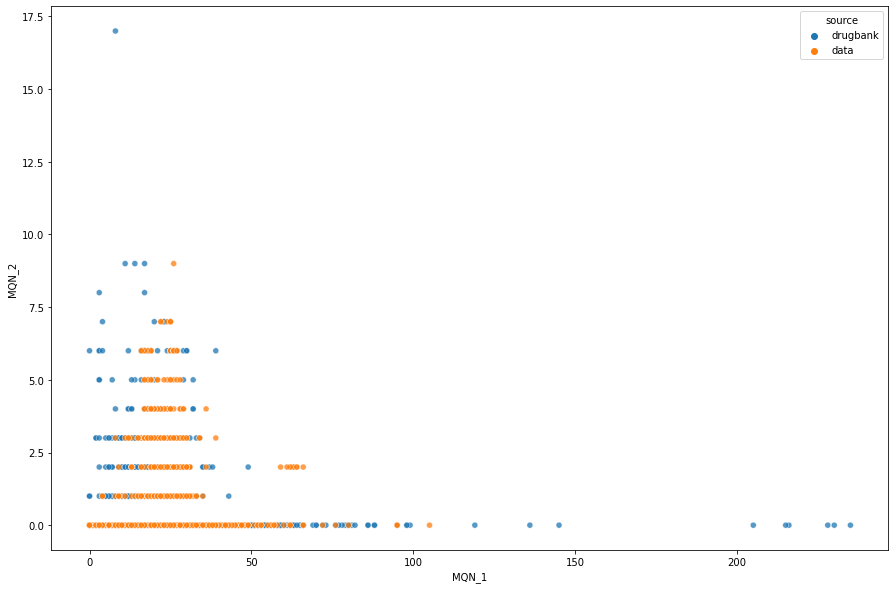

In [11]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="MQN_1",
                      y="MQN_2",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

In [12]:
#tu je sns.pairplot, moving on

In [16]:
pca = decomposition.PCA(n_components=42)
norm = preprocessing.normalize(df[(f"MQN_{x}" for x in range(1, 43))])
pca.fit(norm)
df = df.join(pd.DataFrame(pca.transform(norm), columns=[f"nPCA_{x}" for x in range(1, 43)]))

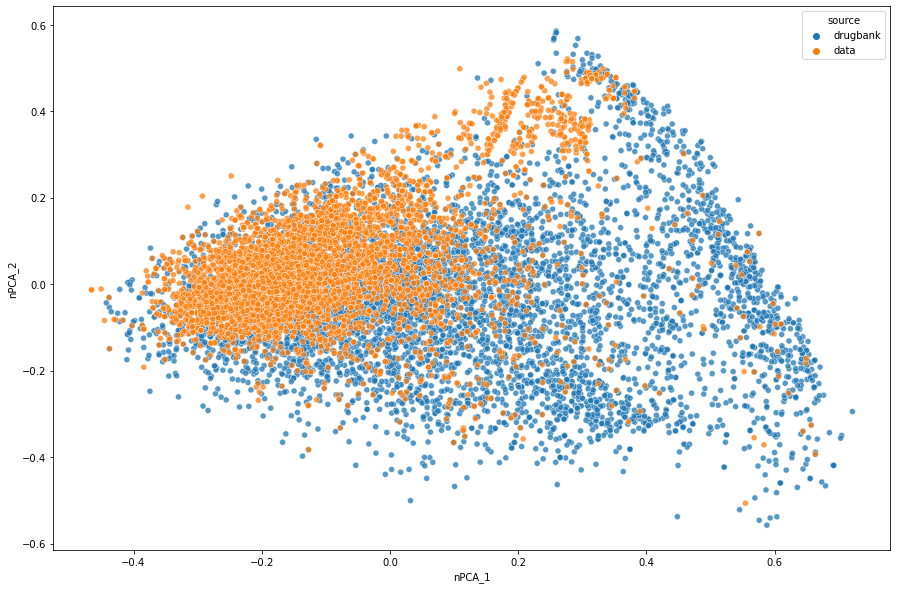

In [17]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="nPCA_1",
                      y="nPCA_2",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

In [18]:
sparse_mat = distance.pdist(list(df["fps"]),metric="jaccard")
dist_mat = distance.squareform(sparse_mat)

clf = manifold.MDS(n_components=2, n_init=1, max_iter=100, dissimilarity="precomputed")
X_mds = clf.fit_transform(dist_mat)

In [19]:
df = df.join(pd.DataFrame(X_mds, columns=["mds_x","mds_y"]))

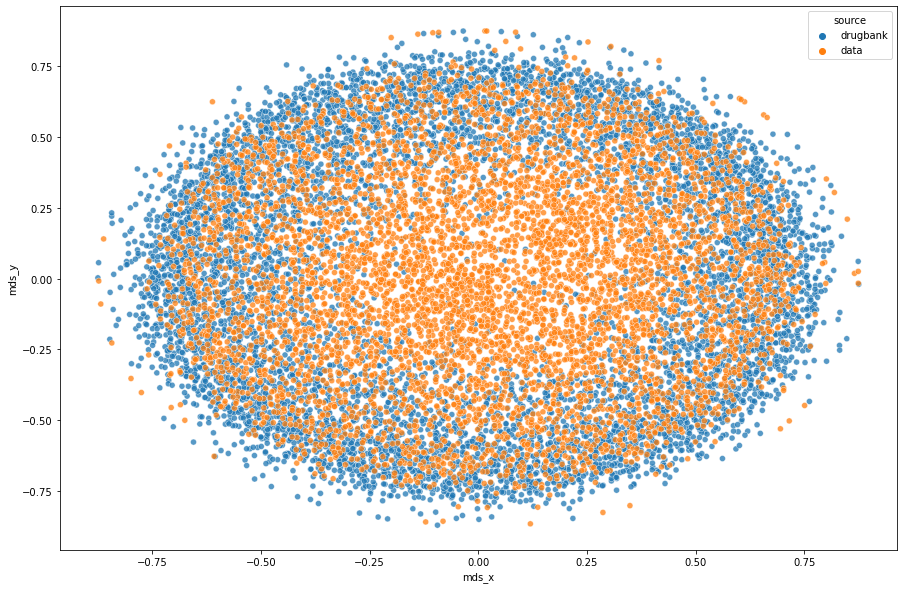

In [20]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="mds_x",
                      y="mds_y",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

In [21]:
clf = manifold.TSNE(n_components=2, metric="precomputed")
X_tsne = clf.fit_transform(dist_mat)

/home/martina/miniconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/martina/miniconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/martina/miniconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


In [22]:
df = df.join(pd.DataFrame(X_tsne, columns=["tsne_x", "tsne_y"]))

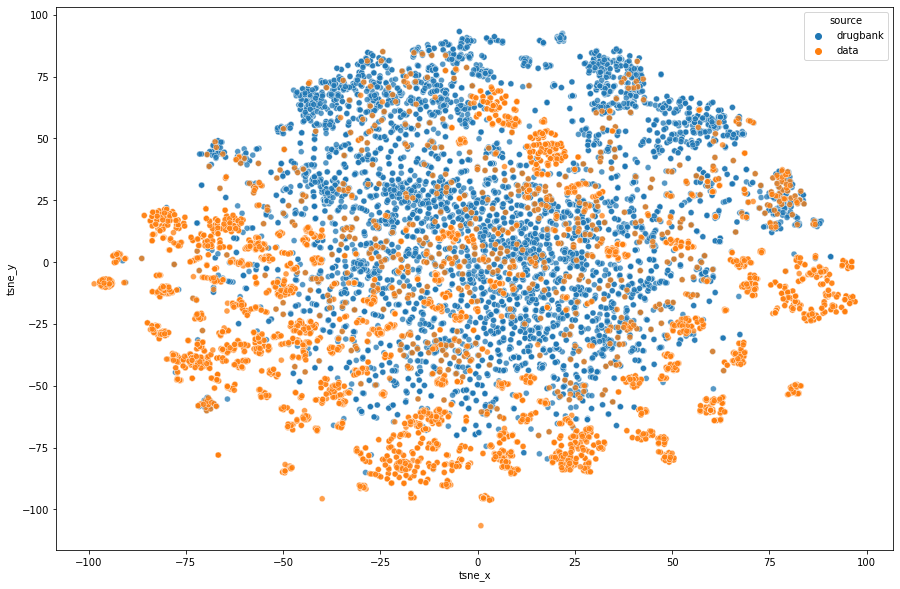

In [23]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="tsne_x",
                      y="tsne_y",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

Poznamka: distance.function(i, j ...) from rdkit.SimDivFilters import MaxMinPicker 
picker.Lazypick

In [24]:
def distance_function(index1, index2, *args, fingerprints=df["fps"],
                      metric=DataStructs.TanimotoSimilarity):
    return 1 - DataStructs.FingerprintSimilarity(fingerprints[index1],
                                                 fingerprints[index2],
                                                 metric=metric)

In [25]:
picker = MaxMinPicker()
picked = list(picker.LazyPick(distance_function, len(df), 45)) #zkousi integery v danem rozmezi a vraci indexy, co vybral
df["picked"] = df.index.isin(picked)

In [32]:
print(df.loc[df['picked'] == True])

       index                                             Smiles    source  \
400      400                                     N[Pt](N)(Cl)Cl  drugbank   
441      441                            FC(F)(F)C(F)(F)C(F)(F)F  drugbank   
645      645                                         [Cl-].[K+]  drugbank   
850      850                                           S=[Se]=S  drugbank   
1188    1188                                              [Li+]  drugbank   
1198    1198                                               [Al]  drugbank   
1199    1199                                             [CaH2]  drugbank   
1202    1202                                             [Mg+2]  drugbank   
1378    1378                                               [Fe]  drugbank   
1379    1379                                               [Zn]  drugbank   
1450    1450                               Nc1nc(O)c2[nH]nnc2n1  drugbank   
1757    1757                               [N-]=[N+]=N[Fe]O[Fe]  drugbank   

In [33]:
picked = df.loc[df['picked'] == True]

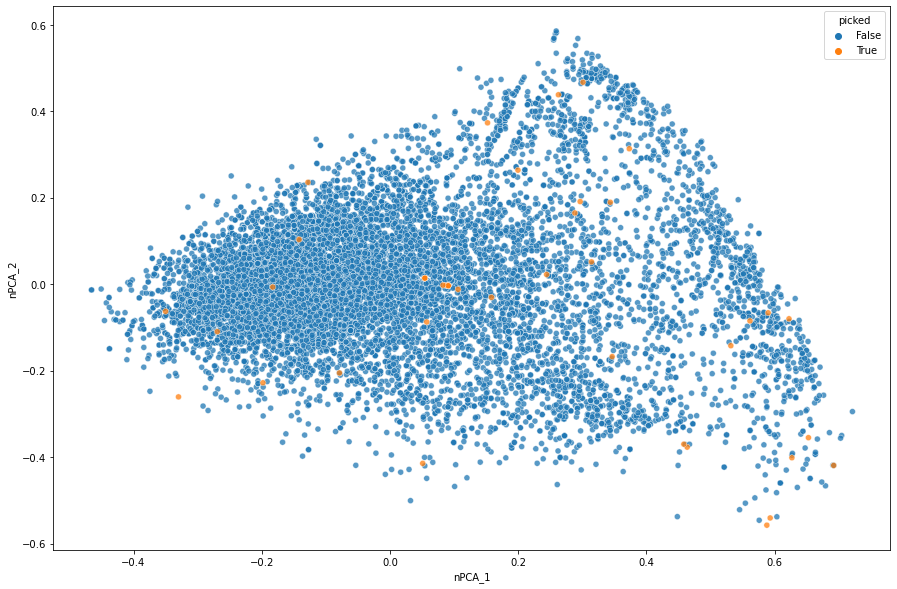

In [26]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="nPCA_1",
                      y="nPCA_2",
                      data=df.sort_values("picked"), # True values are drawn as last so they are better visible 
                      hue="picked",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

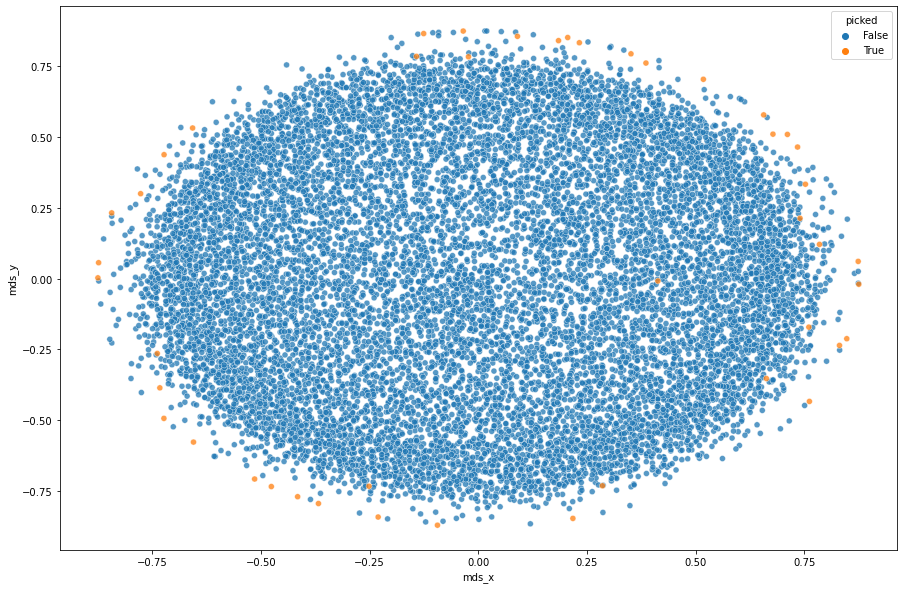

In [27]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="mds_x",
                      y="mds_y",
                      data=df.sort_values("picked"),
                      hue="picked",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

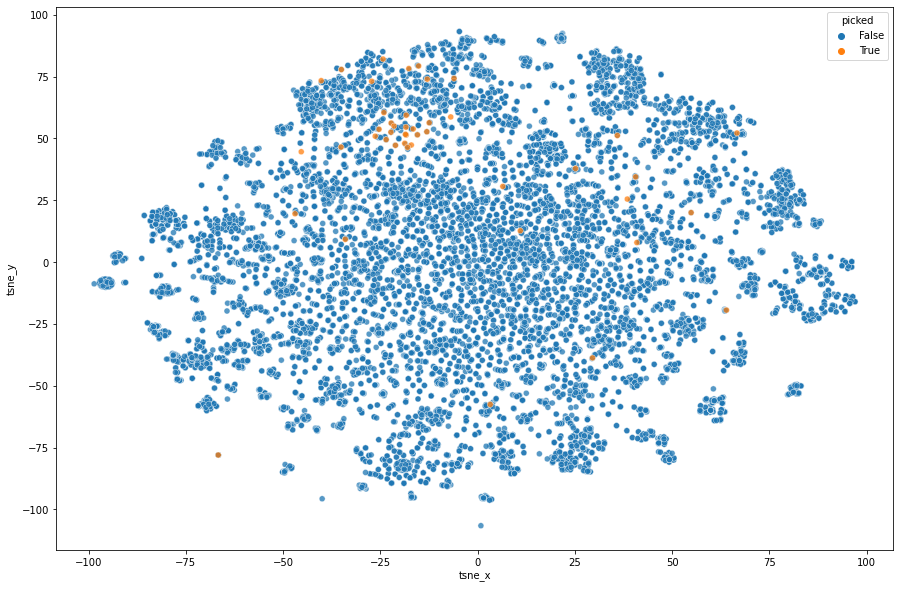

In [28]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="tsne_x",
                      y="tsne_y",
                      data=df.sort_values("picked"),
                      hue="picked",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

In [43]:
Draw.MolsToGridImage(picked['rdmol'], molsPerRow=10, subImgSize=(250,250), useSVG=True)

> ?????   
¬.¬   
°^°

In [62]:
mol = picked.loc[picked['index'] == 2366]
mol = mol['rdmol']
mol

2366    <rdkit.Chem.rdchem.Mol object at 0x7fecd2c41ee0>
Name: rdmol, dtype: object

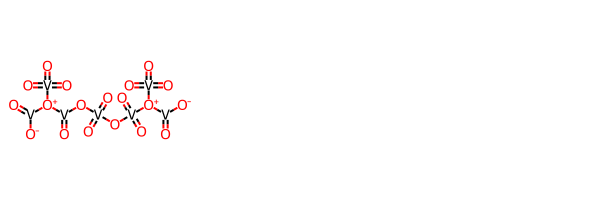

In [63]:
Draw.MolsToGridImage(mol)

Scaffolding
==========

-- zobecnění na kostru

In [79]:
print(picked['Smiles'])

400                                         N[Pt](N)(Cl)Cl
441                                FC(F)(F)C(F)(F)C(F)(F)F
645                                             [Cl-].[K+]
850                                               S=[Se]=S
1188                                                 [Li+]
1198                                                  [Al]
1199                                                [CaH2]
1202                                                [Mg+2]
1378                                                  [Fe]
1379                                                  [Zn]
1450                                  Nc1nc(O)c2[nH]nnc2n1
1757                                  [N-]=[N+]=N[Fe]O[Fe]
2152                                             O[Sb](O)O
2205                         CC(C)=CCC/C(C)=C\CC/C(C)=C\CO
2366     O=[V]([O-])[O+]([V](=O)O[V](=O)(=O)O[V](=O)(=O...
2610                                           [S-]SSS[S-]
2646                                        [NH3+]C1CCCC

In [86]:
picked.at[3050, 'Smiles']

'O=C(NCc1ccccc1)c1cccc(O[C@H]2O[C@H](CO)[C@H](O)[C@H](O)[C@H]2O)c1'

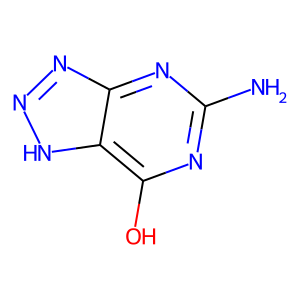

In [90]:
m = Chem.MolFromSmiles('Nc1nc(O)c2[nH]nnc2n1')
Draw.MolToImage(m)

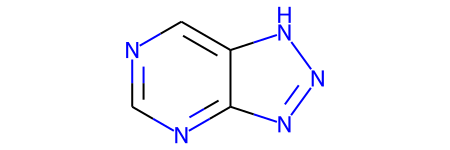

In [91]:
Scaffolds.MurckoScaffold.GetScaffoldForMol(m)

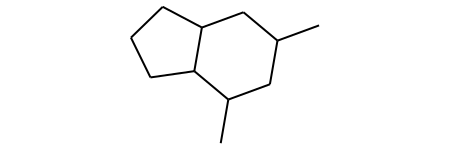

In [92]:
Scaffolds.MurckoScaffold.MakeScaffoldGeneric(m)

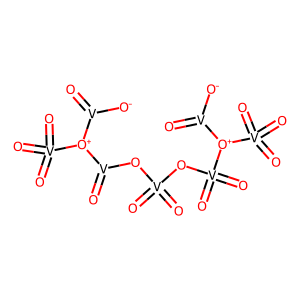

In [93]:
m = Chem.MolFromSmiles('O=[V]([O-])[O+]([V](=O)O[V](=O)(=O)O[V](=O)(=O)[O+]([V](=O)[O-])[V](=O)(=O)=O)[V](=O)(=O)=O')
Draw.MolToImage(m)

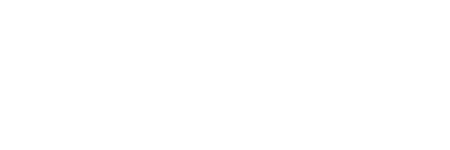

In [94]:
Scaffolds.MurckoScaffold.GetScaffoldForMol(m)

again, wot? jasny, nema to cykly

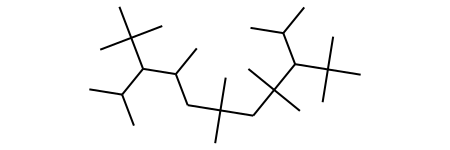

In [96]:
Scaffolds.MurckoScaffold.MakeScaffoldGeneric(m)

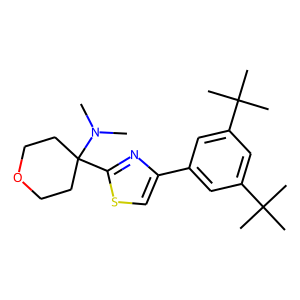

In [97]:
m = Chem.MolFromSmiles('CN(C)C1(c2nc(-c3cc(C(C)(C)C)cc(C(C)(C)C)c3)cs2)CCOCC1')
Draw.MolToImage(m)

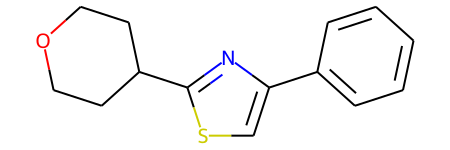

In [98]:
Scaffolds.MurckoScaffold.GetScaffoldForMol(m)

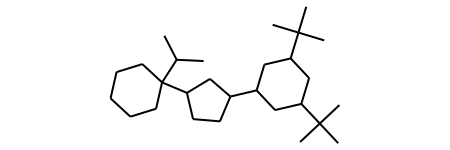

In [99]:
Scaffolds.MurckoScaffold.MakeScaffoldGeneric(m)

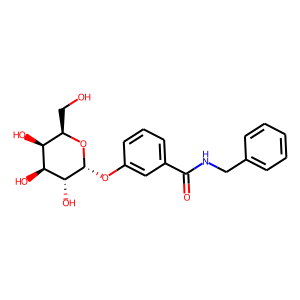

In [87]:
m = Chem.MolFromSmiles('O=C(NCc1ccccc1)c1cccc(O[C@H]2O[C@H](CO)[C@H](O)[C@H](O)[C@H]2O)c1')
Draw.MolToImage(m)

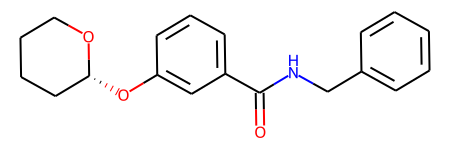

In [88]:
Scaffolds.MurckoScaffold.GetScaffoldForMol(m)

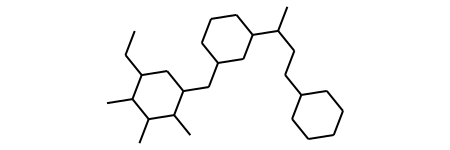

In [89]:
Scaffolds.MurckoScaffold.MakeScaffoldGeneric(m)